## 安裝套件

In [1]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q

## 引入 package

In [2]:
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import requests
import datasets
import gc
from PIL import Image
from textwrap import wrap
from transformers import AutoProcessor
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from datasets import load_dataset
from evaluate import load

In [3]:
wer = load("wer")

In [4]:
"""
畫出多組的圖片文字配對
"""
def plot_images(images, captions):
  plt.figure(figsize=(20, 20))
  for i in range(len(images)):
    ax = plt.subplot(1, len(images), i + 1)
    caption = captions[i]
    caption = "\n".join(wrap(caption, 12)) # 把句子拆成一行最多 12 個字的 list，再用換行連接起來
    plt.title(caption)
    plt.imshow(images[i])
    plt.axis("off")


"""
對影像文字做前處理
"""
def transforms(batch):
  images = [x for x in batch["image"]]
  captions = [x for x in batch["text"]]
  inputs = processor(images=images, text=captions, padding="max_length") # 圖片預設會等比例縮小，然後 crop 中間的部分
  inputs.update({"labels": inputs["input_ids"]})
  return inputs

"""
計算 Word Error Rate (WER)
"""
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predicted = logits.argmax(-1)
  decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
  decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
  wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
  return {"wer_score": wer_score}

"""
計算 Accuracy
"""
def compute_accuracy(eval_pred):
  logits, labels = eval_pred
  predicted = logits.argmax(-1)
  decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
  decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)

  correct_predictions = 0
  for i in range(len(decoded_labels)):
    if decoded_labels[i] == decoded_predictions[i]:
      correct_predictions += 1

  accuracy = correct_predictions / len(decoded_labels)
  
  return {"accuracy": accuracy}

## 讀取資料集

In [5]:
ds = load_dataset("imagefolder", data_dir="./drive/MyDrive/new_cat_dog_dataset")

Resolving data files:   0%|          | 0/901 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
print(ds)
print(ds["train"][0]["text"])

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 900
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 100
    })
})
cat


In [7]:
"""
切出 train/test dataset
"""
# ds = load_dataset("lambdalabs/pokemon-blip-captions")
# print(ds)
# ds = ds["train"].train_test_split(test_size=0.1, shuffle=True) # 預設 shuffle 是 true
train_ds = ds["train"].shuffle(seed=23)
test_ds = ds["test"].shuffle(seed=23)

In [8]:
print(type(train_ds))
print(train_ds)
print(type(train_ds[0]["image"]))

<class 'datasets.arrow_dataset.Dataset'>
Dataset({
    features: ['image', 'text'],
    num_rows: 900
})
<class 'PIL.JpegImagePlugin.JpegImageFile'>


(318, 349, 3)


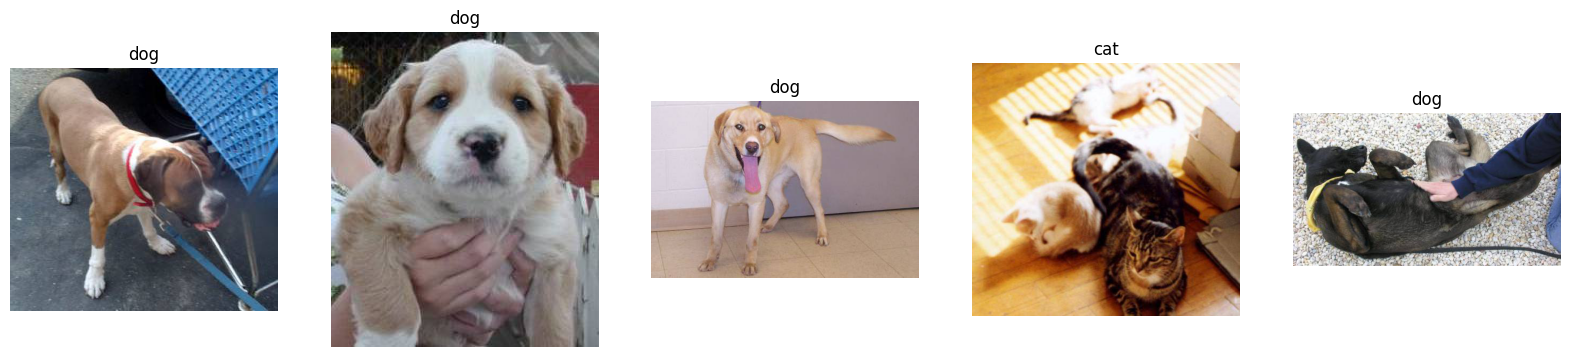

In [9]:
sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)
print(sample_images_to_visualize[0].shape)

In [10]:
checkpoint = "microsoft/git-base"

In [11]:
"""
設置 processor
"""
processor = AutoProcessor.from_pretrained(checkpoint)

In [12]:
train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [13]:
model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [14]:
"""
Trainging
"""

gc.collect()
torch.cuda.empty_cache()

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-cat-dog",
    learning_rate=5e-5,
    num_train_epochs=10,
    fp16=True, # CUDA 才能用
    # fp16=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2, # 會自動修改 eval step
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True, # 預設用 eval loss
    optim="adamw_torch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    # compute_metrics=compute_metrics,
    compute_metrics=compute_accuracy,
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,7.395800,4.534961,0.700000
100,2.344900,0.438612,0.620000
150,0.117000,0.007695,0.500000
200,0.005100,0.003051,0.650000
250,0.002700,0.001506,0.960000
300,0.001700,0.001144,0.960000
350,0.001400,0.001038,0.980000
400,0.001000,0.000844,0.980000
450,0.000900,0.000887,0.970000
500,0.000800,0.000932,0.960000


TrainOutput(global_step=560, training_loss=0.881435640525472, metrics={'train_runtime': 1229.2662, 'train_samples_per_second': 7.321, 'train_steps_per_second': 0.456, 'total_flos': 4173599859941376.0, 'train_loss': 0.881435640525472, 'epoch': 9.91})

In [15]:
# """
# Inference
# """
# url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
# image = Image.open(requests.get(url, stream=True).raw)
# image

Resolving data files:   0%|          | 0/901 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

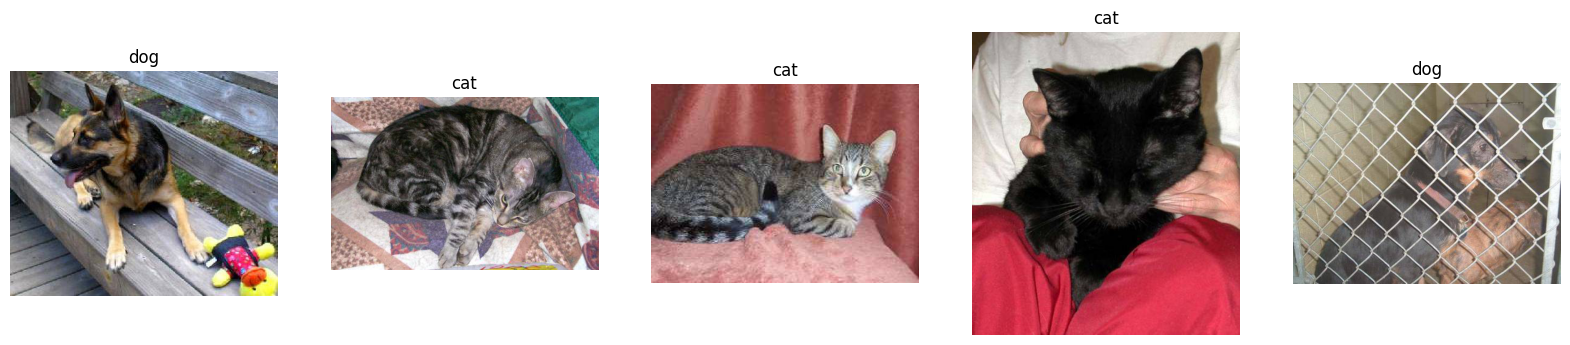

In [17]:
"""
Inference
"""
test_ds = load_dataset("imagefolder", data_dir="./drive/MyDrive/new_cat_dog_dataset")["test"].shuffle(seed=23)

sample_images_to_visualize = [np.array(test_ds[i]["image"]) for i in range(5)]
sample_captions = [test_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

for image in sample_images_to_visualize:
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  print(generated_caption)

dog
cat
cat
cat
dog


In [19]:
num_correct = 0
num_total = 0

for example in test_ds:
  image = example["image"]
  text = example["text"]

  # 進行預測
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values
  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  # 比較預測結果和標籤是否相同
  if generated_text == text:
    num_correct += 1

  num_total += 1

accuracy = num_correct / num_total
print(f"準確度：{accuracy:.2%}")

準確度：98.00%
